In [28]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.12.0
Eager execution: True


In [29]:
train_dataset_fp = "./src/cs_data_ml_training.csv"

In [30]:
column_names = ['gender', 'age', 'humidity', 'temperature', 'pm2_5', 'pm10', 'is_asthmatic','comfort_level']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['gender', 'age', 'humidity', 'temperature', 'pm2_5', 'pm10', 'is_asthmatic']
Label: comfort_level


In [31]:
comfort_level_desc = ['good','not so good','danger']

In [32]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [34]:
features, labels = next(iter(train_dataset))

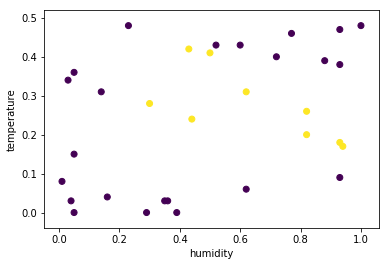

In [35]:
plt.scatter(features['humidity'],
            features['temperature'],
            c=labels,
            cmap='viridis')

plt.xlabel("humidity")
plt.ylabel("temperature");

In [36]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [37]:
train_dataset = train_dataset.map(pack_features_vector)

In [38]:
features, labels = next(iter(train_dataset))

In [39]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(7,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [40]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=448082, shape=(5, 3), dtype=float32, numpy=
array([[-0.19266477, -2.4410403 , -1.569657  ],
       [-0.09677517, -2.1749332 , -1.3594857 ],
       [ 0.15502022, -1.5557513 , -1.2404579 ],
       [ 0.1550372 , -2.9884768 , -2.2550056 ],
       [-0.3449521 , -1.6504228 , -0.78656995]], dtype=float32)>

In [41]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=448088, shape=(5, 3), dtype=float32, numpy=
array([[0.7364275 , 0.07774509, 0.18582745],
       [0.7102037 , 0.08888949, 0.20090683],
       [0.700064  , 0.12651996, 0.17341605],
       [0.88265735, 0.03806987, 0.07927275],
       [0.52245504, 0.14160877, 0.33593613]], dtype=float32)>

In [42]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 2 2 2 1 1 2 1 1 1 1 1]


In [43]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 2.3321354389190674


In [44]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [45]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

In [46]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 3217, Initial Loss: 2.3321354389190674
Step: 3218,         Loss: 2.081958055496216


In [49]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.608, Accuracy: 61.672%
Epoch 050: Loss: 0.483, Accuracy: 80.896%
Epoch 100: Loss: 0.343, Accuracy: 88.078%
Epoch 150: Loss: 0.280, Accuracy: 90.098%
Epoch 200: Loss: 0.264, Accuracy: 90.818%


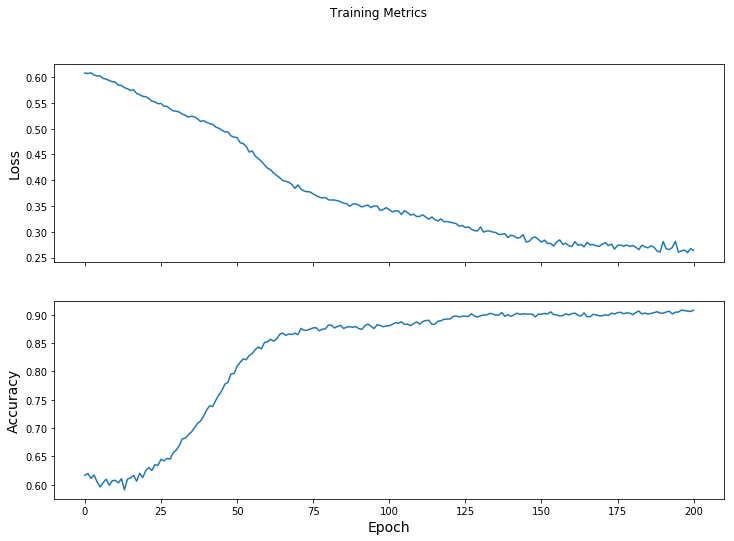

In [50]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

In [51]:
test_fp  = "./src/cs_data_ml_test.csv"

In [52]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name='comfort_level',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [53]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 84.770%


In [56]:
class_names = ['good','not so good','danger']

gender = int(input("gender 1/0: "))
age = int(input("age 1-70: "))

humidity = int(input("humidity 0-100: "))
temperature = int(input("temperature 0-50: "))
pm2_5 = int(input("pm2_5 0-300: "))
pm10 = int(input("pm10 0-300: "))

is_asthmatic = int(input("is_asthmatic 1/0: "))

age /= 10
humidity /= 100
temperature /= 100
pm2_5 /= 100
pm10 /= 100

logits = [gender,age,humidity,temperature,pm2_5,pm10,is_asthmatic]
class_idx = tf.argmax(logits).numpy()
p = tf.nn.softmax(logits)[class_idx]
name = class_names[class_idx]
print("class id: " + str(class_idx))
print("Example prediction: {} ({:4.1f}%)".format(name, 100*p))

gender 1/0: 1
age 1-70: 20
humidity 0-100: 60
temperature 0-50: 19
pm2_5 0-300: 2
pm10 0-300: 3
is_asthmatic 1/0: 0
class id: 1
Example prediction: not so good (45.6%)
